In [1]:
import numpy as np 
import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import datetime
from sklearn.decomposition import PCA, KernelPCA
from numpy import linalg as LA
import plotly.graph_objs as go
import plotly.colors as colors

In [2]:
X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/churchland.npy') 
X = jnp.array(X) 
K, N, T = X.shape
print(X.shape)

(108, 218, 61)


In [5]:
def pre_processing(X,
               soft_normalize = 'churchland',
               soft_normalize_value = 5,
               center=True,
               pca=True,
               num_pcs=30):
        
        K, N, T = X.shape
        if soft_normalize == 'churchland': 
            """ soft-normalized to approximately unity firing rate range (divided by a normalization factor equal 
            to the firing rate range + 5 spikes per s) (Elsayed, 2017)"""
            range = jnp.max(X, axis=(0,2), keepdims=True) - jnp.min(X, axis=(0,2), keepdims=True)
            X = X / (range + soft_normalize_value)
        else:
            norm_const = jnp.maximum(jnp.max(X, axis=(0,2),  keepdims=True ), 0.1)
            X = X / norm_const
                
        if center:
            condition_mean = jnp.mean(X, axis=0, keepdims=True)
            X = X - condition_mean

        pca_variance_captured = None

        if pca:
            X_reshaped = np.concatenate(X.swapaxes(1,2))
            pca = PCA(num_pcs)
            X = pca.fit_transform(X_reshaped)
            X = X.reshape(K, T, num_pcs).swapaxes(1,2)
            pca_variance_captured = pca.explained_variance_

        return jnp.array(X), pca_variance_captured

X, _ = pre_processing(X)

In [6]:
def single_pair_loss(U_tilde, X, id_1, id_2):                           #U (N,d); X(K,N,T)

    Y = jnp.einsum('ji,jk->ik', U_tilde, X[id_1, :, :])                 #(d,T)
    Y_prime = jnp.einsum('ji,jk->ik', U_tilde, X[id_2, :, :])           #(d,T)

    YY = jnp.einsum('ij,kj->ik', Y, Y_prime)                            #(d,d)
    YY_product = jnp.einsum('ij,lm->im', YY, YY)                        #(d,d)

    S_pair = jnp.trace(YY)**2 - jnp.trace(YY_product)
    return S_pair

def loss(params, X, key, s_learn):  
    K, N, T = X.shape

    if s_learn:
        U = params['U']
        s = params['s'] 

        s_normalized = jnp.sqrt(N) * (s**2) /  jnp.linalg.norm(s**2)
        X_scaled = s_normalized[None, :, None] * X
    else:
        U = params
        X_scaled = X
    
    U_tilde, _ = jnp.linalg.qr(U)

    num_pairs = 10  
    indices = random.randint(key, shape=(num_pairs*2,), minval=0, maxval=N)
    index_pairs = indices.reshape((num_pairs, 2))

    batched_loss = vmap(single_pair_loss, in_axes=(None, None, 0, 0))(U_tilde, X_scaled, index_pairs[:, 0], index_pairs[:, 1]) #(num_pairs)

    S = (2 / (num_pairs**2) ) * jnp.sum(batched_loss)
    return -S

def update_U(params, X, optimizer, opt_state, key, s_learn):
    grad = grad(loss)(params,X,key, s_learn)
  
    updates, opt_state_updated = optimizer.update(grad, opt_state, params)
    params_updated = optax.apply_updates(params, updates)
    return params_updated, opt_state_updated

def optimize(X, s_learn=False, iterations=10000, learning_rate=0.001, d=3, seed=42):
    K, N, T = X.shape

    key = random.PRNGKey(seed)
    
    U = random.normal(key, (N, d))
    s = random.normal(key, (N,)) 

    if s_learn:
        params = {
            'U': U,
            's': s
        }
    else: 
        params = U 

    keys = random.split(key, num=iterations)

    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
    
    ls_loss = []

    cmap = plt.get_cmap('viridis')
    for i in range(iterations):
        params, opt_state = update_U(params, X, optimizer, opt_state, keys[i], s_learn)
        
        ls_loss.append(loss(params, X, keys[i], s_learn))
        
        if i % 10 == 0:
            print(f"Iteration {i}, S: {-loss(params, X, keys[i], s_learn)}")
            
        # if i % 100 == 0:
        #     plt.figure()
        #     plt.plot(ls_loss)
        #     plt.savefig(f'outputs/linear_sca/fig_saved/loss_lr_{learning_rate}_iter_{iterations}_d_{d}.png' )
        #     #plt.plot(params['s_dict'], color=cmap(i / (iterations - 1)))
    
    
    return params, ls_loss

s_learn = True
iterations=10000
learning_rate=0.001
d = 3
optimized_params, ls_loss = optimize(X, s_learn, iterations, learning_rate, d)               

optimized_U = optimized_params['U']
optimized_s = optimized_params['s']

# now = datetime.datetime.now()
# date_time_str = now.strftime('%d%m%Y_%H%M%S')

# save_path_U = f'outputs/linear_sca/optimized_U_linear_SCA/optimized_U_lr_{learning_rate}_iter_{iterations}_d_{d}_{date_time_str}' 
# if s_learn:
#     optimized_U = optimized_params['U']     #(N,d)
#     optimized_s = optimized_params['s']     #(N,)
#     np.save(save_path_U, optimized_U)

#     save_path_s = f'outputs/linear_sca/optimized_U_linear_SCA/optimized_S_lr_{learning_rate}_iter_{iterations}_d_{d}_{date_time_str}' 
#     np.save(save_path_s, optimized_s)

# else:
#     optimized_U = optimized_params
#     np.save(save_path_U, optimized_U)



Iteration 0, S: -5.574738679570146e-07
Iteration 10, S: -1.9682789798025624e-07
Iteration 20, S: 5.083726932753052e-07
Iteration 30, S: -1.2573333378895768e-06
Iteration 40, S: 4.851267476624344e-07
Iteration 50, S: 5.340869506653689e-07
Iteration 60, S: -3.102394714460388e-07
Iteration 70, S: -2.994034730363637e-06
Iteration 80, S: -2.169100952187364e-07
Iteration 90, S: 4.1215332657884574e-07
Iteration 100, S: -1.1534209676256069e-07
Iteration 110, S: 1.1998777154076379e-06
Iteration 120, S: -1.2904290258575202e-07
Iteration 130, S: 3.128421610654186e-07
Iteration 140, S: 1.9140934170991386e-07
Iteration 150, S: 2.052731133517227e-06
Iteration 160, S: 9.186015148543447e-08
Iteration 170, S: 9.948864772013621e-07
Iteration 180, S: 2.9206387353042373e-07
Iteration 190, S: 3.3977428870457516e-07
Iteration 200, S: 1.724085052501323e-07
Iteration 210, S: 3.1736983601149404e-06
Iteration 220, S: 1.2423288353602402e-06
Iteration 230, S: 7.299381650227588e-07
Iteration 240, S: 8.736559493627

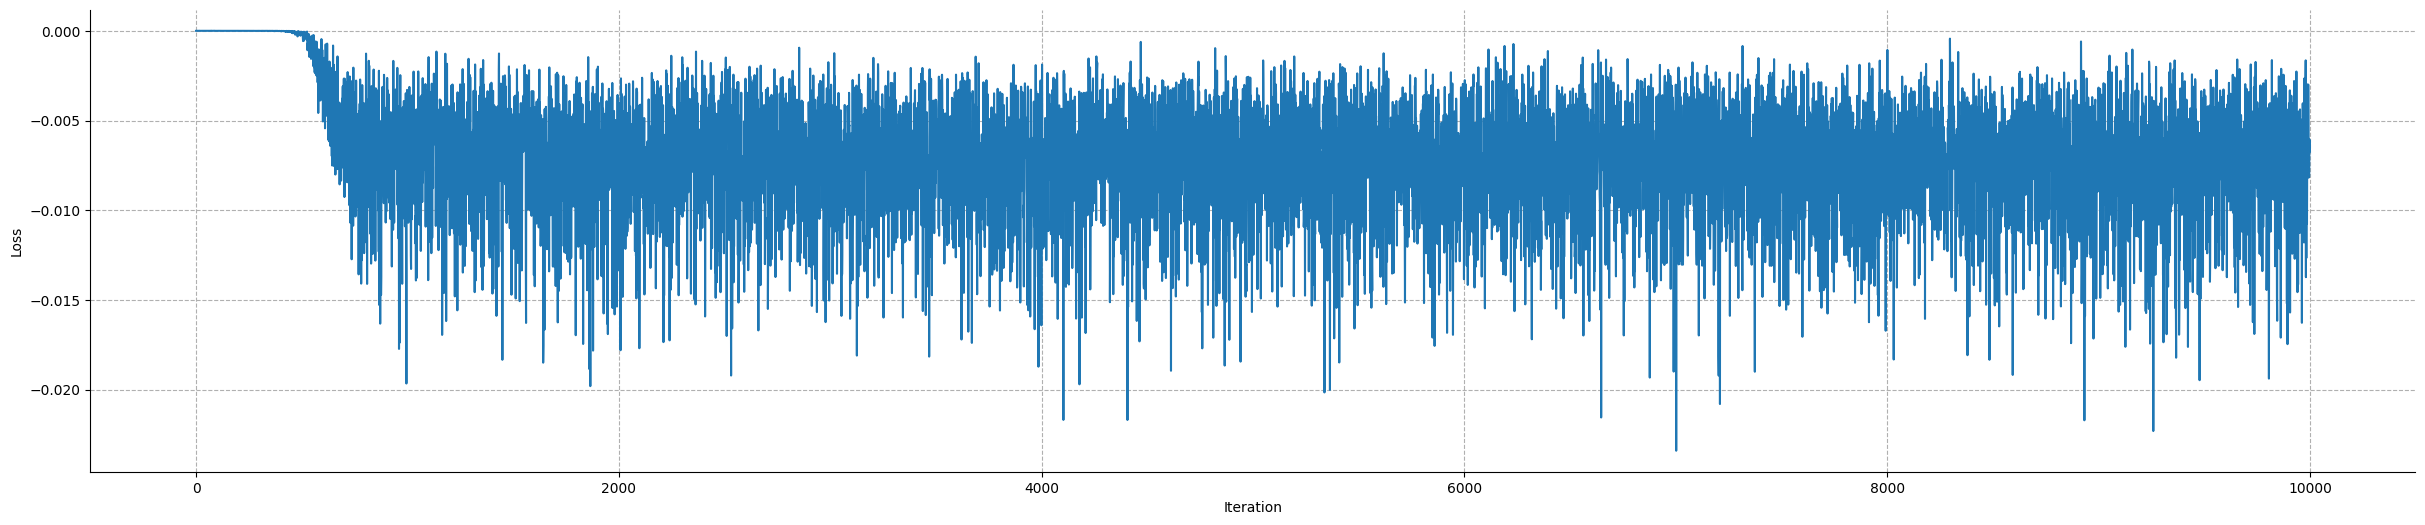

In [7]:
plt.figure(figsize=(30, 6))
plt.plot(ls_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True, which="both", ls="--") 
plt.gca().spines[['right', 'top']].set_visible(False)


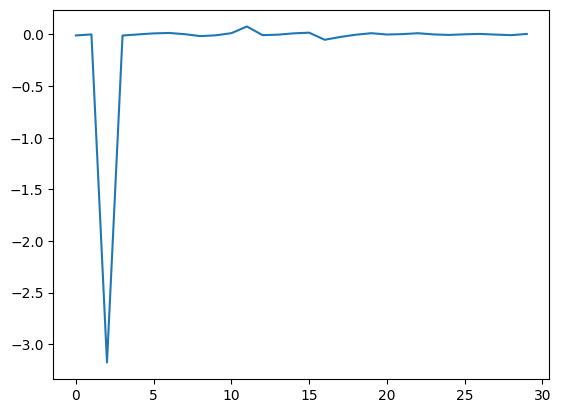

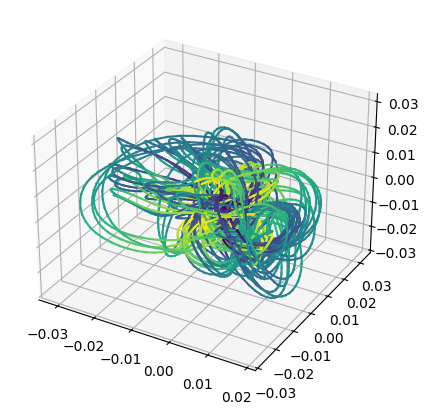

In [14]:


s_normalized = jnp.sqrt(X.shape[1]) * (optimized_s ** 2) / jnp.linalg.norm(optimized_s ** 2)
X_scaled = s_normalized[None, :, None] *  X

plt.plot(s_normalized)

optimized_U_tilde, _ = jnp.linalg.qr(optimized_U)        
Y = jnp.einsum('ji,kjl->kil', optimized_U_tilde, X )         #(K,d,T) 

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap('viridis')

num_time_points = Y.shape[-1]
indices_to_plot = np.arange(0,Y.shape[0],1)

for i in indices_to_plot:
    x = Y[i, 0, :]  
    y = Y[i, 1, :] 
    z = Y[i, 2, :]  

    
    for t in range(num_time_points - 1):
        ax.plot(x[t:t+2], y[t:t+2], z[t:t+2], color=cmap(t / (num_time_points - 1)))

#Set the axis limits
# min = -7
# max = 7
# ax.set_xlim([min, max])
# ax.set_ylim([min, max])
# ax.set_zlim([min, max])


In [62]:
def make_frame(angle):
    ax.view_init(angle, 30)
    fig.canvas.draw() 
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image

angles = range(0,360, 2) 
frames = [make_frame(angle) for angle in angles]

#gif_path = date_time_str + "_trajectories_rotation.gif"
gif_path = "trajectories_rotation.gif"
imageio.mimsave(gif_path, frames, fps=20)


gif_path

/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_31303/824884034.py:4: MatplotlibDeprecationWarning:

The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.



'trajectories_rotation.gif'

In [7]:
fig = go.Figure()

for i in indices_to_plot:
    x = Y[i, 0, :]
    y = Y[i, 1, :]
    z = Y[i, 2, :]

    for t in range(num_time_points - 1):
        color_scale = colors.sequential.Viridis
        color_index = int(t / (num_time_points - 1) * (len(color_scale) - 1))
        fig.add_trace(go.Scatter3d(
            x=x[t:t+2],
            y=y[t:t+2],
            z=z[t:t+2],
            mode='lines',
            line=dict(color=color_scale[color_index]),
            showlegend=False
        ))

# fig.update_layout(
#     scene=dict(
#         xaxis=dict(title='X', range=[min, max]),
#         yaxis=dict(title='Y', range=[-0.5, 0.5]),
#         zaxis=dict(title='Z', range=[min, max])
#     )
# )

fig.show()

ENDS HERE 